In [1]:
import __init__path
import os
import numpy as np
import pandas as pd

from lib.preprocess.selectCellType import read_allCelltypeFile, \
read_bloodCelltypeFile, read_histoneList


def read_feature_importances(feature_importances_filepath):
    filecontent = open(feature_importances_filepath,'r').readlines()
    features = [item.strip() for item in filecontent[0].split('\t')]
    importances = [float(item.strip()) for item in filecontent[1].split('\t')]
    return features, importances

def sort_feature_by_importances(feature_importances_filepath,feature_type_name):
    features, importances = read_feature_importances(feature_importances_filepath)
    if feature_type_name == 'gene':
        histones_overlap = []
        histones_importances = []
        for ind,featurename in enumerate(features):
            if featurename.endswith('gene'):
                if featurename not in ['expressionMean','expressionVar',
                                       'TssDistance','methyMean','methyVar']:
                    histones_overlap.append(featurename)
                    histones_importances.append(importances[ind])
        histone_sorted = [histones_overlap[ind] for ind in np.argsort(np.array(histones_importances))[::-1]]
    elif feature_type_name == 'cpg':
        histones_overlap = []
        histones_importances = []
        for ind,featurename in enumerate(features):
            if not featurename.endswith('gene'):
                if featurename not in ['expressionMean','expressionVar',
                                       'TssDistance','methyMean','methyVar']:
                    histones_overlap.append(featurename)
                    histones_importances.append(importances[ind])
        histone_sorted = [histones_overlap[ind] for ind in np.argsort(np.array(histones_importances))[::-1]]
    return histone_sorted

project_rootdir = '/home/shuang/projects/development_eqtm'
feature_importances_filepath = os.path.join(project_rootdir,
                                            'data',
                                            'features',
                                            'feature_importances',
                                            'featureImportances_allCellType_gt.txt')
celltype_dir = os.path.join(project_rootdir, 'data', 'features', 'celltype')
blood_celltype_filepath = os.path.join(celltype_dir, 'roadmap-celltypes-blood-MJ.txt')
all_celltype_filepath = os.path.join(celltype_dir, 'roadmap-celltypes.txt')
histonelist_filepath = os.path.join(project_rootdir, 'data', 'features', 'histonetype',
                                    '2017-12-09-eQTLsFDR-et0.0-flipped_histoneList.txt')
cpg_overlapMatrix_filepath = os.path.join(project_rootdir, 'data', 'eqtmZscores',
                        'complete_overlapMatrix',
                        '2017-12-09-eQTLsFDR-gt0.0-flipped_overlapMatrixcomplete.txt')

In [4]:
blood_celltype = read_bloodCelltypeFile(blood_celltype_filepath)
all_celltype = read_allCelltypeFile(all_celltype_filepath)
histones = read_histoneList(histonelist_filepath)
sorted_histone = sort_feature_by_importances(feature_importances_filepath,'cpg')
sorted_features = []
for celltype in blood_celltype:
    for histone in sorted_histone:
        feature_name = '{}-{}'.format(celltype,histone)
        sorted_features.append(feature_name)
for celltype in [item for item in all_celltype.keys() if item not in blood_celltype]:
    for histone in sorted_histone:
        feature_name = '{}-{}'.format(celltype,histone)
        sorted_features.append(feature_name)

overlapMatrix = pd.read_csv(cpg_overlapMatrix_filepath,sep=',',index_col=0)
overlapMatrix['E005-H4K12ac'] = 0
overlapMatrix['E008-H3T11ph'] = 0
overlapMatrix['E017-H2AK9ac'] = 0

In [6]:
content = overlapMatrix[sorted_features].values

In [7]:
overlapMatrix[sorted_features].head()

,E029-H3T11ph,E029-H4K12ac,E029-H3K4me2,E029-H4K8ac,E029-H2BK12ac,E029-H3K27ac,E029-H4K20me1,E029-H3K4me1,E029-H3K79me1,E029-H3K23me2,...,E112-H3K9me3,E112-H3K4me3,E112-H3K23ac,E112-H3K79me2,E112-H2A.Z,E112-H3K14ac,E112-H2BK15ac,E112-H2BK120ac,E112-H3K36me3,E112-H3K9me1
cg05661533,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,0,0,0,0,1,0
cg02570223,0,1,1,1,0,1,0,1,1,1,...,0,1,0,1,1,1,0,1,0,0
cg10458142,1,1,1,1,1,1,0,1,1,1,...,0,1,1,1,1,1,0,1,1,0
cg05864876,0,1,1,0,0,1,0,1,0,0,...,0,1,0,0,1,1,0,1,0,0
cg08456754,0,1,0,1,0,1,1,1,1,0,...,0,0,0,1,0,0,0,0,1,0


In [24]:
cpg_save_dirpath = os.path.join(project_rootdir,
                                'data','cpgSites',
                                'seperate_cpgFiles')
num_cell_types = len(all_celltype.keys())
num_histones = len(histones)
for ind,cpg_name in enumerate(overlapMatrix.index):
    cpg_save_filepath = os.path.join(cpg_save_dirpath,cpg_name+'.txt')
    cpg_file = open(cpg_save_filepath,'w')
    for i in range(0,content.shape[1],num_cell_types):
        line_to_write = content[ind,i:i+num_cell_types]
        cpg_file.write('\t'.join([str(item) for item in line_to_write]))
        cpg_file.write('\n')
    cpg_file.close()

In [19]:
content[10,content.shape[1]-num_cell_types:content.shape[1]]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0])

In [7]:
num_all_celltypes = len(all_celltype.keys())
num_histones = len(histones)


In [8]:
cpg_overlapMatrix.head()

,E084-H4K5ac,E124-H2A.Z,E069-H2BK120ac,E024-H3K79me2,E069-H4K5ac,E116-H3K27ac,E076-H2BK20ac,E042-H3K79me2,E073-H3K14ac,E078-H3K79me2,...,E008-H3K9ac,E067-H3K27ac,E091-H3K36me3,E090-H3K79me2,E029-H3K4ac,E109-H2BK20ac,E069-H3K9ac,E076-H3K4me1,E037-H2AK5ac,E053-H3K14ac
cg05661533,0,0,0,1,0,1,0,1,0,1,...,0,0,1,1,1,0,0,0,0,0
cg02570223,1,1,1,0,1,1,0,1,1,1,...,1,1,0,1,1,0,1,1,0,1
cg10458142,1,1,1,1,1,1,0,1,1,1,...,1,1,0,1,1,0,1,1,1,1
cg05864876,1,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,1,1,0
cg08456754,0,0,0,1,0,1,0,1,0,1,...,0,0,1,1,0,0,0,0,0,0


In [11]:
def rearrange_cpgs(overlapMatrix_filepath,
                   type_name,
                    blood_celltype_filepath,
                    all_celltype_filepath,
                    histonelist_filepath,
                    feature_importances_filepath,
                    save_dirpath):
    blood_celltype = read_bloodCelltypeFile(blood_celltype_filepath)
    all_celltype = read_allCelltypeFile(all_celltype_filepath)
    histones = read_histoneList(histonelist_filepath)
    sorted_histone = sort_feature_by_importances(feature_importances_filepath,type_name)
    sorted_features = []
    for celltype in blood_celltype:
        for histone in sorted_histone:
            feature_name = '{}-{}'.format(celltype,histone)
            sorted_features.append(feature_name)
    for celltype in [item for item in all_celltype.keys() if item not in blood_celltype]:
        for histone in sorted_histone:
            feature_name = '{}-{}'.format(celltype,histone)
            sorted_features.append(feature_name)

    overlapMatrix = pd.read_csv(overlapMatrix_filepath,sep=',',index_col=0)
    overlapMatrix['E005-H4K12ac'] = 0
    overlapMatrix['E008-H3T11ph'] = 0
    overlapMatrix['E017-H2AK9ac'] = 0

    for cpg_name in overlapMatrix.index:
        cpg_filepath = os.path.join(save_dirpath,cpg_name+'.txt')
        cpg_file = open(cpg_filepath,'w')
        for ind in range(0,num_histones*num_all_celltypes,num_histones):
            features = sorted_features[ind:ind+num_histones]
            cpg_file.write('\t'.join([str(item) for item in overlapMatrix[features].loc[cpg_name]]))
            cpg_file.write('\n')
        cpg_file.close()
    print("Saved all seperate cpg files in dirpath: %s"%save_dirpath)

In [ ]:
cpg_save_dirpath = os.path.join(project_rootdir,
                                'data','cpgSites',
                                'seperate_cpgFiles')
gene_save_dirpath = os.path.join(project_rootdir,
                                'data','features',
                                'geneOverlap')
rearrange_cpgs(overlapMatrix_filepath,
               'cpg',
               blood_celltype_filepath,
               all_celltype_filepath,
               histonelist_filepath,
               feature_importances_filepath,
               cpg_save_dirpath)
rearrange_cpgs(overlapMatrix_filepath,
               'gene',
               blood_celltype_filepath,
               all_celltype_filepath,
               histonelist_filepath,
               feature_importances_filepath,
               gene_save_dirpath)

In [13]:
cpg_overlapMatrix[sorted_features].head()

,E029-H3T11ph,E029-H4K12ac,E029-H3K4me2,E029-H4K8ac,E029-H2BK12ac,E029-H3K27ac,E029-H4K20me1,E029-H3K4me1,E029-H3K79me1,E029-H3K23me2,...,E112-H3K9me3,E112-H3K4me3,E112-H3K23ac,E112-H3K79me2,E112-H2A.Z,E112-H3K14ac,E112-H2BK15ac,E112-H2BK120ac,E112-H3K36me3,E112-H3K9me1
cg05661533,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,0,0,0,0,1,0
cg02570223,0,1,1,1,0,1,0,1,1,1,...,0,1,0,1,1,1,0,1,0,0
cg10458142,1,1,1,1,1,1,0,1,1,1,...,0,1,1,1,1,1,0,1,1,0
cg05864876,0,1,1,0,0,1,0,1,0,0,...,0,1,0,0,1,1,0,1,0,0
cg08456754,0,1,0,1,0,1,1,1,1,0,...,0,0,0,1,0,0,0,0,1,0


In [24]:
cpg_overlapMatrix[['E084-H4K5ac','E124-H2A.Z']].loc['cg05661533'].values

array([0, 0])

In [28]:
print(len((os.listdir(save_dirpath))))

17460


In [29]:
test_filepath = os.path.join(save_dirpath,'cg05661533.txt')
test_data = open(test_filepath,'r').readlines()


In [30]:
cpg_data = []
for line in test_data:
    cpg_data.append([int(item) for item in line.split('\t')])

In [34]:
import matplotlib.pyplot as plt
% matplotlib inline

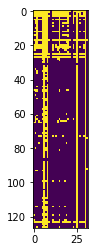

In [35]:
plt.imshow(np.array(cpg_data))
plt.show()

In [39]:
cpg_overlapMatrix.loc['cg05661533'][sorted_features]

E029-H3T11ph      1
E029-H4K12ac      1
E029-H3K4me2      1
E029-H4K8ac       1
E029-H2BK12ac     1
E029-H3K27ac      1
E029-H4K20me1     1
E029-H3K4me1      1
E029-H3K79me1     1
E029-H3K23me2     1
E029-H3K27me3     0
E029-H4K5ac       1
E029-H2BK20ac     1
E029-H2AK5ac      1
E029-H3K4ac       1
E029-DNase        1
E029-H2AK9ac      1
E029-H4K91ac      1
E029-H2BK5ac      1
E029-H3K18ac      1
E029-H3K9ac       1
E029-H3K56ac      1
E029-H3K9me3      0
E029-H3K4me3      1
E029-H3K23ac      1
E029-H3K79me2     1
E029-H2A.Z        1
E029-H3K14ac      1
E029-H2BK15ac     1
E029-H2BK120ac    1
                 ..
E112-H3K4me2      1
E112-H4K8ac       0
E112-H2BK12ac     0
E112-H3K27ac      1
E112-H4K20me1     1
E112-H3K4me1      1
E112-H3K79me1     1
E112-H3K23me2     0
E112-H3K27me3     0
E112-H4K5ac       0
E112-H2BK20ac     0
E112-H2AK5ac      0
E112-H3K4ac       0
E112-DNase        1
E112-H2AK9ac      0
E112-H4K91ac      0
E112-H2BK5ac      0
E112-H3K18ac      0
E112-H3K9ac       0
